# Introduction

In this notebook I will train a Neural Process on a set of regression tasks:
the aim of each task is to asppoximate a function. The common traint of all 
tasks (i.e. functions to approximate) is that they are generated by a sine
function. What varies across tasks is the amplitude and the period

<img src="https://www.mathsisfun.com/algebra/images/period-amplitude.svg" alt="period and amplitude">

using the formula

$$y = a \cdot \text{sin}\left(bx\right)$$

where $a$ is the amplitude and $2\pi/b$ is the period.

### Load required packages

In [1]:
import attentive_neural_process as nep
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline

### Create the training datasets

Sizes
  x: (80, 1) 
  y: (80, 1) 
for each task


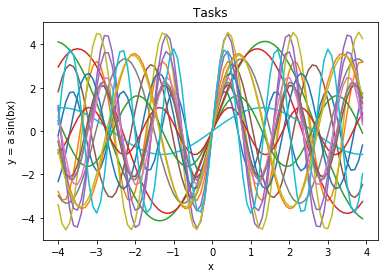

In [2]:
datasets = {}
n_tasks = 20

x_np = np.arange(-4, 4, 0.1).reshape(-1, 1).astype(np.float32)

for i in range(n_tasks):
    a = np.random.uniform(1, 5)
    b = np.random.uniform(1, 5)
    y_np = a * np.sin(b * x_np)
    datasets['task_{}'.format(i)] = y_np 
    plt.plot(x_np, y_np)
plt.title('Tasks')
plt.ylabel('y = a sin(bx)')
plt.xlabel('x')
print('Sizes\n', ' x:', x_np.shape, '\n  y:', y_np.shape, '\nfor each task')
plt.show()

### Parameter initialization

In [38]:
r_dim = 7
s_dim = 2
z_dim = 2

r_encoder_specs = [(8, torch.nn.ReLU()), (r_dim, None)]
s_encoder_specs = [(8, torch.nn.ReLU()), (s_dim, None)]
decoder_specs = [(8, torch.nn.Sigmoid()), (y_np.shape[1], None)]

context_indim = x_np.shape[1] + y_np.shape[1]
target_indim = x_np.shape[1]
encoder_indim = context_indim 
decoder_indim = x_np.shape[1] + z_dim + r_dim

In [39]:
r_selfatt = nep.SelfAttention(context_indim, r_dim)
r_crossatt = nep.CrossAttention(context_indim, target_indim, r_dim)
s_selfatt = nep.SelfAttention(context_indim, s_dim)

# r_encoder = nep.R_encoder(encoder_indim, r_encoder_specs)
# s_encoder = nep.S_encoder(encoder_indim, s_encoder_specs)
s_to_z = nep.Zparams(s_dim, z_dim)
decoder = nep.Decoder(decoder_indim, decoder_specs)
optimizer = torch.optim.Adam(params=list(decoder.parameters()) + \
                             list(r_selfatt.parameters()) + \
                             list(r_crossatt.parameters()) + \
                             list(s_selfatt.parameters()) + \
                             list(s_to_z.parameters()), 
                             lr=1e-3)

### Training

A crucial property of NPs is their flexibility at test time, as they can model
a whole range of functions and narrow down their prediction as we condition on
an increasing number of context observations. This behaviour is a result of the
training regime of NPs which is reflected in our datasets.

<img src="https://bit.ly/2O2Lq8c" alt="drawing" width="600"/> 

Rather than training using observations from a single function as it is often
the case in machine learning (for example value functions in reinforcement
learning) we will use a dataset that consists of many different functions that
*share* some underlying characteristics. This is visualized in the figure above.

The example on the left corresponds to a classic training regime: we have a
single underlying ground truth function (eg. our value function for an agent) in
grey and at each learning iteration we are provided with a handful of examples from 
this function that we have visualized in different colours for batches of different
iterations. On the right we show an example of a dataset that could be used for
training neural processes. Instead of a single function, it consists of a large number 
of functions of a function-class that we are interested in modeling. At each iteration 
we randomly choose one from the dataset and provide some observations from that function 
for training. 
For the next iteration we put that function back and pick a new one from our dataset and 
use this new function to select the training data. This type of dataset ensures that our 
model can't overfit to a single function but rather learns a distribution over functions. 
This idea of a hierarchical dataset also lies at the core of current meta-learning methods.
Examples of such datasets could be:

We have chosen GPs for the data generation of this example because they
constitute an easy way of sampling smooth curves that share some underlying
characteristic (in this case the kernel). Other than for data generation of this
particular example neural processes do not make use of kernels or GPs as they
are implemented as neural networks.

In [28]:
epochs = 2000
n_z_samples = 10
losses = []
kl = []
nll = []
tasks = {key: 0 for key,_ in datasets.items()}


for epoch in range(epochs):
    optimizer.zero_grad()
    
    # Select a task randomly
    task_id = 'task_' + str(np.random.randint(0, n_tasks))
    y_np = datasets[task_id]
    tasks[task_id] += 1
    
    # Context/Target split: select number of context points randomly in {1,...,5}
    n_context = np.random.randint(1,5)
    x_c, y_c, x_t, y_t = nep.randsplit_totensor(x_np, y_np, n_context)
    x_all = torch.from_numpy(x_np)
    y_all = torch.from_numpy(y_np)
    
    # Determinstic path
    xy_c = torch.cat([x_c, y_c], dim=1)
    r_i = r_selfatt(xy_c)
    r = r_crossatt(x_t, xy_c, r_i)
    
    # Latent path
    s = s_selfatt(xy_c).mean(dim=0)
    z_mean, z_logvar = s_to_z(s)
    z_std = torch.exp(0.5 * z_logvar)

    # Compute z using the entire sample for the KL, for later use
    xy_all = torch.cat([x_all, y_all], dim=1)
    s_all = s_selfatt(xy_all).mean(dim=0)
    z_mean_all, z_logvar_all = s_to_z(s_all)
    z_std_all = torch.exp(0.5 * z_logvar_all)
    
    # Prepare inputs for decoder, use `n_z_samples` samples of z for later use
    z = nep.sample_z(z_mean, z_logvar, how_many=n_z_samples)
    zr_concat = torch.cat([z, r.expand(z.shape[0], -1)], dim=1)
    zr_concat_reshaped = zr_concat.unsqueeze(1).expand(-1, x_t.shape[0], -1)
    x_t_reshaped = x_t.unsqueeze(0).expand(z.shape[0], x_t.shape[0], x_t.shape[1])
    xzr_concat = torch.cat([x_t_reshaped, zr_concat_reshaped], dim=2)
    
    # Decoder, outputs `n_z_samples` vectors of means and logvars for y
    y_mean, y_logvar = decoder(xzr_concat)
    y_mean, y_logvar = y_mean.squeeze(), y_logvar.squeeze()
    y_std = torch.exp(0.5 * y_logvar)
    
    # MC estimate of NLL
    NLL = nep.neg_loglik(y_mean, y_std, y_t)
    
    # KL divergence
    KL = nep.KL_div(z_mean, z_std, z_mean_all, z_std_all)
    
    # Compute loss
    loss = NLL + KL
    
    # Record data
    losses.append(loss)
    kl.append(KL)
    nll.append(NLL)
    
    # Backprop
    loss.backward()
    
    # Gradient step
    optimizer.step()
    
    if (epoch + 1) % 1000 == 0:
        print('Epoch {} completed'.format(epoch + 1))
        
print('\nTraining epochs for task')
for key, value in tasks.items():
    print(f'  {key}: {value}')

Epoch 1000 completed
Epoch 2000 completed

Training epochs for task
  task_0: 102
  task_1: 100
  task_2: 92
  task_3: 102
  task_4: 119
  task_5: 92
  task_6: 102
  task_7: 104
  task_8: 126
  task_9: 104
  task_10: 83
  task_11: 95
  task_12: 76
  task_13: 115
  task_14: 106
  task_15: 99
  task_16: 84
  task_17: 95
  task_18: 104
  task_19: 100


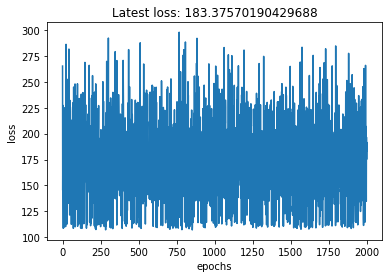

In [29]:
#plt.subplot(2,2,1)
plt.plot(losses)
plt.title('Latest loss: {}'.format(losses[-1]))
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

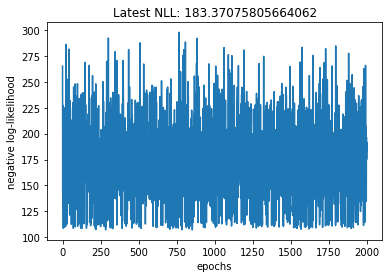

In [30]:
plt.plot(nll)
plt.title('Latest NLL: {}'.format(nll[-1]))
plt.xlabel('epochs')
plt.ylabel('negative log-likelihood')
plt.show()

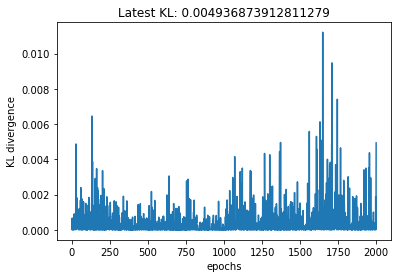

In [31]:
plt.plot(kl)
plt.title('Latest KL: {}'.format(kl[-1]))
plt.xlabel('epochs')
plt.ylabel('KL divergence')
plt.show()

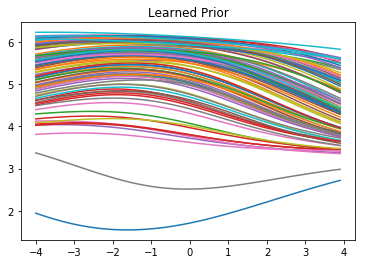

In [40]:
z_sample_all = nep.sample_z(z_mean_all, z_logvar_all, how_many=100)
r_i_all = r_selfatt(xy_all)
r_all = r_crossatt(x_all, xy_all, r_i_all)

zr_c = torch.cat([z_sample_all, r_all.expand(z_sample_all.shape[0], -1)], dim=1)
zr_c_reshaped = zr_c.unsqueeze(1).expand(-1, x_all.shape[0], -1)
x_all_reshaped = x_all.unsqueeze(0).expand(zr_c.shape[0], x_all.shape[0], x_all.shape[1])
xzr_t = torch.cat([x_all_reshaped, zr_c_reshaped], dim=2)

for i in range(xzr_t.shape[0]):
    mean_y, _ = decoder(xzr_t[i])
    plt.plot(x_all.numpy(), mean_y.detach().numpy())
plt.title('Learned Prior')
plt.show()

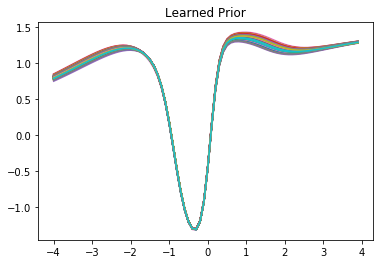

In [35]:
z_sample_all = nep.sample_z(z_mean_all, z_logvar_all, how_many=100)
r_i_all = r_selfatt(xy_all)
r_all = r_crossatt(x_all, xy_all, r_i_all)

zr_c = torch.cat([z_sample_all, r_all.expand(z_sample_all.shape[0], -1)], dim=1)
zr_c_reshaped = zr_c.unsqueeze(1).expand(-1, x_all.shape[0], -1)
x_all_reshaped = x_all.unsqueeze(0).expand(zr_c.shape[0], x_all.shape[0], x_all.shape[1])
xzr_t = torch.cat([x_all_reshaped, zr_c_reshaped], dim=2)

for i in range(xzr_t.shape[0]):
    mean_y, _ = decoder(xzr_t[i])
    plt.plot(x_all.numpy(), mean_y.detach().numpy())
plt.title('Learned Prior')
plt.show()

# Test

In [36]:
x_star = x_np
y_star = 2.5 * np.sin(x_star)

In [37]:
test_epochs = 2000
n_z_samples = 10
test_losses = []
test_kl = []
test_nll = []

n_context = 5
x_c, y_c, x_t, y_t = nep.randsplit_totensor(x_star, y_star, n_context)

for epoch in range(test_epochs):
    optimizer.zero_grad()
    
    # Context/Target split: select number of context points randomly in {1,...,5}
    x_all = torch.from_numpy(x_star)
    y_all = torch.from_numpy(y_star)
    
    # Determinstic path
    xy_c = torch.cat([x_c, y_c], dim=1)
    r_i = r_selfatt(xy_c)
    r = r_crossatt(x_t, xy_c, r_i)
    
    # Latent path
    s = s_selfatt(xy_c).mean(dim=0)
    z_mean, z_logvar = s_to_z(s)
    z_std = torch.exp(0.5 * z_logvar)

    # Compute z using the entire sample for the KL, for later use
    xy_all = torch.cat([x_all, y_all], dim=1)
    s_all = s_selfatt(xy_all).mean(dim=0)
    z_mean_all, z_logvar_all = s_to_z(s_all)
    z_std_all = torch.exp(0.5 * z_logvar_all)
    
    # Prepare inputs for decoder, use `n_z_samples` samples of z for later use
    z = nep.sample_z(z_mean, z_logvar, how_many=n_z_samples)
    zr_concat = torch.cat([z, r.expand(z.shape[0], -1)], dim=1)
    zr_concat_reshaped = zr_concat.unsqueeze(1).expand(-1, x_t.shape[0], -1)
    x_t_reshaped = x_t.unsqueeze(0).expand(z.shape[0], x_t.shape[0], x_t.shape[1])
    xzr_concat = torch.cat([x_t_reshaped, zr_concat_reshaped], dim=2)
    
    # Decoder, outputs `n_z_samples` vectors of means and logvars for y
    y_mean, y_logvar = decoder(xzr_concat)
    y_mean, y_logvar = y_mean.squeeze(), y_logvar.squeeze()
    y_std = torch.exp(0.5 * y_logvar)
    
    # MC estimate of NLL
    NLL = nep.neg_loglik(y_mean, y_std, y_t)
    
    # KL divergence
    KL = nep.KL_div(z_mean, z_std, z_mean_all, z_std_all)
    
    # Compute loss
    loss = NLL + KL
    
    # Record data
    losses.append(loss)
    kl.append(KL)
    nll.append(NLL)
    
    # Backprop
    loss.backward()
    
    # Gradient step
    optimizer.step()

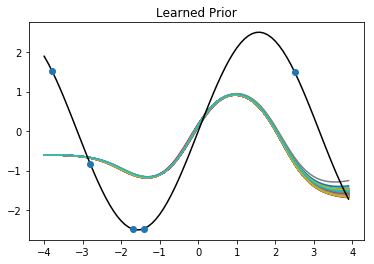

In [11]:
z_sample_all = nep.sample_z(z_mean_all, z_logvar_all, how_many=100)
r_i_all = r_selfatt(xy_all)
r_all = r_crossatt(x_all, xy_all, r_i_all)

zr_c = torch.cat([z_sample_all, r_all.expand(z_sample_all.shape[0], -1)], dim=1)
zr_c_reshaped = zr_c.unsqueeze(1).expand(-1, x_all.shape[0], -1)
x_all_reshaped = x_all.unsqueeze(0).expand(zr_c.shape[0], x_all.shape[0], x_all.shape[1])
xzr_t = torch.cat([x_all_reshaped, zr_c_reshaped], dim=2)

for i in range(xzr_t.shape[0]):
    mean_y, _ = decoder(xzr_t[i])
    plt.plot(x_all.numpy(), mean_y.detach().numpy())
plt.title('Learned Prior')
plt.plot(x_star, y_star, 'k')
plt.plot(x_c.detach().numpy(), y_c.detach().numpy(), 'o')
plt.show()